In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps
import math

In [4]:
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

def plaw_pspec_to_2pcf(const, delta):
    alpha = 3 - delta
    A = const * (sps.gamma(alpha/2))/ (np.power(2, 1 - alpha/2) * sps.gamma((3 - alpha)/2))
    return A, alpha

def plaw_2pcf_to_pspec(A, alpha):
    delta = 3 - alpha
    const = A * (np.power(2, 1 - alpha/2) * sps.gamma((3 - alpha)/2)) / (sps.gamma(alpha/2))
    return const, delta

class clust_dist:
    def __init__(self, N_side, dx, n_bar) -> None:
        self.N_side = N_side
        self.dx = dx
        self.n_bar = n_bar
        #dk of the fourier lattice.
        self.dk = 2 * np.pi/(self.N_side * self.dx)

        #Creating a box with N_side^3 dimension and fill it with poisson random numbers with lambda=n_bar.
        self.box_p = np.random.poisson(lam=n_bar, size=(N_side, N_side, N_side))
        print("Poisson lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - n_bar)/n_bar
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")
    
    def calc_powerspec_pois(self, k_intervals):
        #Finding the powerspectrum here. Iterate through the k_for_P and find the index of modk_grid with k
        #that falls between and find power spectrum pk.
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk[np.where((self.modk_grid >= k1) & (self.modk_grid < k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def update_k_intervals(self, k_intervals):
        ##Assert that the given k_intervals have appropriate k_min and k_max
        assert k_intervals[0] == self.k_min
        # assert k_intervals[-1] == self.k_max
        #updating the k_intervals
        self.k_intervals = np.copy(k_intervals)
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)

    def make_clust_dist(self, powerspec_clust, k_intervals):
        #Making the new box_delk_clust. Right now, whenever we call this method, the previous box_delk_clust if any
        #will be erased.
        self.box_delk_clust = np.copy(self.box_delk)
        #Modifying the box-delk_clust to have the input powerspectrum.
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            temp_ind = np.where((self.modk_grid >= k1) & (self.modk_grid < k2))
            self.box_delk_clust[temp_ind] = self.box_delk[temp_ind] * (np.sqrt(powerspec_clust[i] + self.powerspec_pois[i])) / np.sqrt(self.powerspec_pois[i])
        #Defining the input powerspec as the powerspec of box_delk_clust
        self.powerspec_clust = np.copy(powerspec_clust)
        self.update_k_intervals(k_intervals)
        #Now we need to inverse fourier transfor box_delk_clust to get box_delx_clust
        self.box_delx_clust = np.fft.ifftn(self.box_delk_clust, norm='ortho')
        temp_factor = np.power(self.dk * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delx_clust = temp_factor * self.box_delx_clust
        #Create the new n(x) array.
        self.box_GN = self.n_bar * (1 + self.box_delx_clust)
        print("Made the clustered distribution.")

    def make_clust_dist_from_plaw_pspec(self, const, delta, k_intervals):
        temp_pk = const * np.power(self.k_intervals_mid, -delta)
        self.make_clust_dist(temp_pk, k_intervals) 

    def calc_2pcorrfunc_clust(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_mid = np.arange(x_min_int, x_max_int) * self.dx
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(np.arange(x_min_int, x_max_int)):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def fit_2pcf_clust(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc)
        self._2pcf_fit_alpha = temp_popt[1]
        self._2pcf_fit_A = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

    def initialize_gauss(self, lam, sig):
        #Creating a box with N_side^3 dimension and fill it with Gaussian random numbers with lambda=lam and sigma = sig.
        self.box_p = np.random.normal(loc=lam, scale=sig, size=(self.N_side, self.N_side, self.N_side))
        print("Gaussian lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - lam)/lam
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")

## Where it all begins

Poisson lattice is created.
Poisson power spectrum calculated.
Gaussian lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_24012/4149894030.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


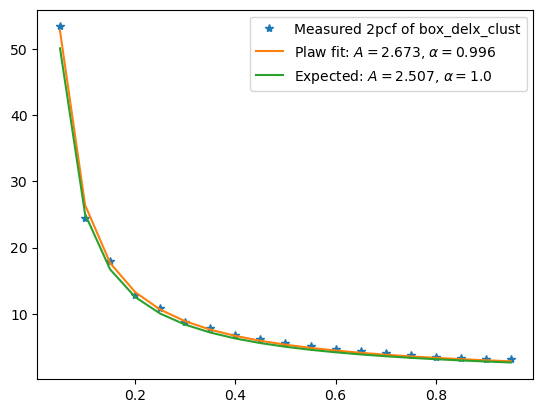

In [7]:
N_side = 256
dx = 0.05
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 1.0

sample_clust = clust_dist(N_side, dx, n_bar)

sample_clust.initialize_gauss(50, 5)
# print(sample_clust.k_intervals)
# new_k_intervals = np.concatenate((np.linspace(sample_clust.k_min, (sample_clust.k_max)/2, N_side//4), np.linspace((sample_clust.k_max)/2, sample_clust.k_max, N_side//2)))
# new_k_intervals = np.linspace(sample_clust.k_min, sample_clust.k_max, N_side)
# sample_clust.update_k_intervals(new_k_intervals)
# print(sample_clust.k_intervals)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1 * dx, 20 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

## 2pcf measurement - Corrfunc

## 2pcf measurement - Direct